# Packages

In [6]:
# Visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network

# Data analysis / Data processing
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', None)
pd.options.display.float_format = "{:,.2f}".format
from datetime import time, timedelta, datetime
import numpy as np
import networkx as nx
from collections import defaultdict
import ast

# Maths & Stats
import math 
import scipy.stats as st
from scipy import stats
from scipy.stats import norm
import statsmodels.stats.weightstats as ws
from statsmodels.stats.proportion import test_proportions_2indep
import AB_library
# from ambrosia.designer import Designer
# from ambrosia.tester import Tester
import expab
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil

# System library
import os
import ipywidgets
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
tqdm.pandas()
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format='retina'
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)
import openpyxl

# Data connection
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='analytics-dev-333113')


# Useful functions
def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def display_side_by_side(*args):

    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {date} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    counter = 0

    for date in daterange:
        counter+=1
        print(f"{counter}) Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df  

def writing_excel(name:str, dataset1=None, dataset2=None, dataset3=None, dataset4=None):
    with pd.ExcelWriter(f"{name}.xlsx") as writer:

    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet

        if dataset1 is not None:
            if dataset2 is not None:
                if dataset3 is not None:
                    if dataset4 is not None:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                        dataset4.to_excel(writer, sheet_name=f"4-{name}", 
                                        #   index=False
                                            )
                    else:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                else:
                    dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                    #   index=False
                                        )
                    dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                    #   index=False
                                        )
            else:
                dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                #   index=False
                                    )

        print('DataFrame is written to Excel File successfully.') 

# Research

In [ ]:
df_events = read_bq("""
WITH events AS (SELECT t1.name || COALESCE(('.' || JSON_EXTRACT_SCALAR(payload, '$.button')), '') AS event_name,
                       user_id,
                       os_name,
                       city_id,
                       tz.name                                                                    AS city_name,
                       IF(EXTRACT(HOUR FROM DATETIME(client_time_ts, tz.timezone)) IN
                          (21, 22, 23, 0, 1, 2, 3, 4, 5, 6), 1,
                          0)                                                                      AS night_time_flg,
                       event_dt_part
                FROM indriver-e6e40.emart.product_event t1
                         JOIN indriver-e6e40.ods_monolith.tbl_city tz
                              ON t1.city_id = tz.id
                WHERE 1 = 1
                  AND t1.country_id = 2
                  AND t1.name IN (
                                  'client.intrip_entry.show', 'client.intrip_entry.click', 'client.intrip_report.show',
                                  'client.intrip_report.click', 'client.intrip_report_result.show',
                                  'client.intrip_report_result.click', 'client.intrip_ok_button.show',
                                  'client.intrip_ok_button.click'
                    )
                  AND event_dt_part BETWEEN '2025-06-01'
                    AND '2025-07-03')
SELECT DISTINCT *
FROM events
""")

In [204]:
df_events.groupby(['event_name'], as_index=False)['user_id'].nunique().sort_values('user_id', ascending=False)

,event_name,user_id
3,client.intrip_entry.show,891
1,client.intrip_entry.click.ok,392
5,client.intrip_ok_button.show,387
4,client.intrip_ok_button.click,329
2,client.intrip_entry.click.report,19
7,client.intrip_report.show,19
0,client.intrip_entry.click.call,3
6,client.intrip_report.click,2
8,client.intrip_report_result.show,1


## Events

In [82]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import os 


df = df_events # Используем ваш DataFrame df_events

df['event_dt_part'] = pd.to_datetime(df['event_dt_part'])

# Полный список событий, определяющий возможные узлы
event_order = [
    'client.intrip_entry.show',
    'client.intrip_entry.click.call',
    'client.intrip_entry.click.report',
    'client.intrip_entry.click.ok',
    'client.intrip_report.show',
    'client.intrip_ok_button.show', 
    'client.intrip_report.click',
    'client.intrip_report_result.show',
    'client.intrip_ok_button.click' 
]

# --- 2. Обработка данных для переходов и подсчетов (СНОВА С разделением общих узлов в названиях) ---

df_sorted = df.sort_values(by=['user_id', 'event_dt_part'])
df_filtered = df_sorted[df_sorted['event_name'].isin(event_order)].copy()

transitions_raw = []

for user_id in df_filtered['user_id'].unique():
    user_events = df_filtered[df_filtered['user_id'] == user_id].copy() 
    
    current_modified_sequence = [] # Последовательность модифицированных событий для этого пользователя

    if not user_events.empty:
        first_original_event = user_events.iloc[0]['event_name']
        current_modified_sequence.append(first_original_event) 
        
        for i in range(1, len(user_events)):
            current_original_event = user_events.iloc[i]['event_name']
            previous_original_event = user_events.iloc[i-1]['event_name'] 

            if current_original_event == previous_original_event:
                continue
            
            modified_current_event_name = current_original_event 

            if current_original_event == 'client.intrip_ok_button.show':
                if previous_original_event == 'client.intrip_entry.click.call':
                    modified_current_event_name = 'client.intrip_ok_button.show_from_call'
                elif previous_original_event == 'client.intrip_entry.click.ok':
                    modified_current_event_name = 'client.intrip_ok_button.show_from_ok'
            elif current_original_event == 'client.intrip_ok_button.click':
                if len(current_modified_sequence) > 0 and \
                   (current_modified_sequence[-1] == 'client.intrip_ok_button.show_from_call'):
                    modified_current_event_name = 'client.intrip_ok_button.click_from_call'
                elif len(current_modified_sequence) > 0 and \
                     (current_modified_sequence[-1] == 'client.intrip_ok_button.show_from_ok'):
                    modified_current_event_name = 'client.intrip_ok_button.click_from_ok'
            
            current_modified_sequence.append(modified_current_event_name)

    for i in range(len(current_modified_sequence) - 1):
        source_modified = current_modified_sequence[i]
        target_modified = current_modified_sequence[i+1]
        
        source_original = source_modified.replace('_from_call', '').replace('_from_ok', '').replace('_click_from_call', '').replace('_click_from_ok', '')
        target_original = target_modified.replace('_from_call', '').replace('_from_ok', '').replace('_click_from_call', '').replace('_click_from_ok', '')

        is_valid_transition = False
        if source_original == 'client.intrip_entry.show' and target_original in ['client.intrip_entry.click.call', 'client.intrip_entry.click.report', 'client.intrip_entry.click.ok']:
            is_valid_transition = True
        elif source_original == 'client.intrip_entry.click.call' and target_original == 'client.intrip_ok_button.show': 
            is_valid_transition = True
        elif source_original == 'client.intrip_report.show' and target_original == 'client.intrip_report.click':
            is_valid_transition = True
        elif source_original == 'client.intrip_report.click' and target_original == 'client.intrip_report_result.show':
            is_valid_transition = True
        elif source_original == 'client.intrip_entry.click.ok' and target_original == 'client.intrip_ok_button.show': 
            is_valid_transition = True
        elif source_original == 'client.intrip_ok_button.show' and target_original == 'client.intrip_ok_button.click': 
            is_valid_transition = True
        elif source_original == 'client.intrip_entry.click.report' and target_original == 'client.intrip_report.show': # Этот переход был пропущен в предыдущем коде
            is_valid_transition = True
        
        if is_valid_transition:
            transitions_raw.append({'source': source_modified, 'target': target_modified, 'user_id': user_id})

transitions_df = pd.DataFrame(transitions_raw)
sankey_data = transitions_df.groupby(['source', 'target']).agg(value=('user_id', 'nunique')).reset_index()

if sankey_data.empty:
    print("Недостаточно данных для построения диаграммы после фильтрации логических переходов.")
    exit()

# --- Исправлена логика подсчета количества уникальных пользователей для каждого узла ---
node_counts_dict = {}
df_original_event_counts = df_filtered.groupby('event_name')['user_id'].nunique().to_dict()

# Для всех возможных отображаемых узлов
all_possible_display_nodes_for_count = [
    'client.intrip_entry.show',
    'client.intrip_entry.click.call',
    'client.intrip_entry.click.report',
    'client.intrip_entry.click.ok',
    'client.intrip_report.show',
    'client.intrip_ok_button.show_from_call', 
    'client.intrip_ok_button.show_from_ok',   
    'client.intrip_report.click',
    'client.intrip_ok_button.click_from_call', 
    'client.intrip_ok_button.click_from_ok',    
    'client.intrip_report_result.show',
]

for node_name in all_possible_display_nodes_for_count:
    original_name = node_name.replace('_from_call', '').replace('_from_ok', '').replace('_click_from_call', '').replace('_click_from_ok', '')
    
    # Берем количество из df_original_event_counts (т.е. из вашей "таблицы")
    # Это обеспечит корректность чисел, как в вашей таблице.
    node_counts_dict[node_name] = df_original_event_counts.get(original_name, 0)

# Убедимся, что Entry Show имеет корректное начальное количество
if 'client.intrip_entry.show' not in node_counts_dict:
    node_counts_dict['client.intrip_entry.show'] = df_original_event_counts.get('client.intrip_entry.show', 0)

# --- НОВАЯ ЧАСТЬ: Рассчитываем общее начальное количество для процентов ---
total_initial_users = node_counts_dict.get('client.intrip_entry.show', 0)
if total_initial_users == 0:
    # Fallback, если Entry Show имеет 0 пользователей, но есть другие
    total_initial_users = max(node_counts_dict.values()) if node_counts_dict else 1


# --- 3. Настройка пользовательской визуализации ---

# Обновленный список всех возможных узлов (включая контекстные дубликаты)
# Порядок здесь важен для позиционирования
all_display_nodes = [
    'client.intrip_entry.show',
    'client.intrip_entry.click.call',
    'client.intrip_entry.click.report',
    'client.intrip_entry.click.ok',
    'client.intrip_report.show',
    'client.intrip_ok_button.show_from_call', 
    'client.intrip_ok_button.show_from_ok',   
    'client.intrip_report.click',
    'client.intrip_ok_button.click_from_call', 
    'client.intrip_ok_button.click_from_ok',    
    'client.intrip_report_result.show', 
]

# Константы для масштабирования высоты узлов
MAX_NODE_HEIGHT = 0.12 
MIN_NODE_HEIGHT = 0.03 

# Найдем максимальное количество пользователей для масштабирования высоты прямоугольников
# Используем total_initial_users для этой цели, чтобы масштабирование было последовательным
max_users_for_height_scaling = total_initial_users
if max_users_for_height_scaling == 0:
    max_users_for_height_scaling = max(node_counts_dict.values()) if node_counts_dict else 1


# Определим базовые свойства каждого узла (x-положение, y-положение в своей "полосе", относительная ширина)
base_node_definitions = {
    'client.intrip_entry.show':         {'x': 0.1,  'y_lane': 0.5, 'width_factor': 1.0}, 
    # Колонка 2
    'client.intrip_entry.click.call':   {'x': 0.35, 'y_lane': 0.8, 'width_factor': 0.9},
    'client.intrip_entry.click.report': {'x': 0.35, 'y_lane': 0.5, 'width_factor': 0.9},
    'client.intrip_entry.click.ok':     {'x': 0.35, 'y_lane': 0.2, 'width_factor': 0.9},
    # Колонка 3
    'client.intrip_report.show':        {'x': 0.6, 'y_lane': 0.5, 'width_factor': 0.8},
    'client.intrip_ok_button.show_from_ok':   {'x': 0.6, 'y_lane': 0.2, 'width_factor': 0.8}, 
    # Колонка 4 (все конечные клики, кроме report_result_show)
    'client.intrip_report.click':       {'x': 0.8, 'y_lane': 0.5, 'width_factor': 0.7}, 
    'client.intrip_ok_button.click_from_ok':   {'x': 0.8, 'y_lane': 0.2, 'width_factor': 0.7},
    # НОВАЯ КОЛОНКА 5 для report_result_show
    'client.intrip_report_result.show': {'x': 0.95, 'y_lane': 0.35, 'width_factor': 0.6}, 
}

# Рассчитываем конечные свойства узлов (x, y, width, height)
node_props = {}
for node_name, base_props in base_node_definitions.items():
    count = node_counts_dict.get(node_name, 0)
    
    if count <= 2 and count > 0: 
        height = MIN_NODE_HEIGHT
    elif count == 0: 
        height = 0.001 
    else:
        scaled_height = (count / max_users_for_height_scaling) * MAX_NODE_HEIGHT 
        height = max(MIN_NODE_HEIGHT, scaled_height)
    
    width = base_props['width_factor'] * 0.18 

    node_props[node_name] = {
        'x': base_props['x'],
        'y': base_props['y_lane'], 
        'width': width,
        'height': height
    }

short_names_map = {
    'client.intrip_entry.show': 'Entry Show',
    'client.intrip_entry.click.call': 'Click Call',
    'client.intrip_entry.click.report': 'Click Report',
    'client.intrip_entry.click.ok': 'Click OK',
    'client.intrip_report.show': 'Report Show',
    'client.intrip_report.click': 'Report Click',
    'client.intrip_report_result.show': 'Report Result Show',
    'client.intrip_ok_button.show_from_ok': 'OK Button\n(OK Path)',
    'client.intrip_ok_button.click_from_ok': 'OK Button\nClick (OK)',
}

color_scheme = {
    'start': 'rgba(173, 216, 230, 0.9)', 
    'call_path': 'rgba(255, 165, 0, 0.9)', 
    'report_path': 'rgba(0, 128, 0, 0.9)', 
    'ok_path': 'rgba(128, 0, 128, 0.9)', 
    'border_color': 'black' 
}

image_paths = {
    'client.intrip_entry.show': 'images/entry_show.png',
    'client.intrip_entry.click.call': 'images/click_call.png',
    'client.intrip_entry.click.report': 'images/click_report.png',
    'client.intrip_entry.click.ok': 'images/click_ok.png',
    'client.intrip_report.show': 'images/report_show.png',
    'client.intrip_ok_button.show_from_call': 'images/ok_button_show_call.png', 
    'client.intrip_ok_button.show_from_ok': 'images/ok_button_show_ok.png',     
    'client.intrip_report.click': 'images/report_click.png',
    'client.intrip_report_result.show': 'images/report_result_show.png',
    'client.intrip_ok_button.click_from_call': 'images/ok_button_click_call.png', 
    'client.intrip_ok_button.click_from_ok': 'images/ok_button_click_ok.png'      
}


# --- 4. Построение пользовательской диаграммы ---

fig = go.Figure()

for node_name in all_display_nodes: 
    current_count = node_counts_dict.get(node_name, 0)
    # Показываем узел, если он определен в node_props И его количество > 0
    # ИЛИ если вы хотите показывать ВСЕ узлы, даже с 0, измените `and current_count > 0` на `or True`
    if node_name in node_props and current_count > 0: 
        props = node_props[node_name]
        
        draw_rect = props['height'] > 0.005 

        x0 = props['x'] - props['width']/2
        x1 = props['x'] + props['width']/2
        y0 = props['y'] - props['height']/2
        y1 = props['y'] + props['height']/2

        node_color = 'lightgrey' 
        if node_name == 'client.intrip_entry.show':
            node_color = color_scheme['start']
        elif node_name == 'client.intrip_entry.click.call': 
            node_color = color_scheme['call_path']
        elif node_name == 'client.intrip_entry.click.report' or node_name == 'client.intrip_report.show' or node_name == 'client.intrip_report.click' or node_name == 'client.intrip_report_result.show':
            node_color = color_scheme['report_path']
        elif node_name == 'client.intrip_entry.click.ok': 
            node_color = color_scheme['ok_path']
        elif '_from_call' in node_name: 
            node_color = color_scheme['call_path']
        elif '_from_ok' in node_name: 
            node_color = color_scheme['ok_path']
            
        if draw_rect: 
            fig.add_shape(
                type="rect",
                x0=x0, y0=y0, x1=x1, y1=y1,
                fillcolor=node_color,
                line=dict(color=color_scheme['border_color'], width=1.5), 
                layer="below"
            )
        
        # --- ФОРМАТИРОВАНИЕ ТЕКСТА МЕТКИ С ПРОЦЕНТАМИ ---
        display_name = short_names_map.get(node_name, node_name)
        
        # Рассчитываем процент для отображения
        percentage = (current_count / total_initial_users) * 100 if total_initial_users > 0 else 0
        
        fig.add_annotation(
            x=props['x'],
            y=props['y'] + props['height']/2 + 0.02, 
            text=f"<b>{display_name}</b><br>({current_count}, {percentage:.0f}%)", # Формат (321, 13%)
            showarrow=False,
            font=dict(
                size=15,        
                color="black",
                family="Arial"  
            ), 
            xanchor="center",
            yanchor="bottom" 
        )

        if node_name in image_paths and os.path.exists(image_paths[node_name]):
            img_x_center = props['x']
            img_area_height = 0.1 
            
            img_y_center = props['y'] - props['height']/2 - img_area_height/2 - 0.02 
            
            img_width_actual = props['width'] * 0.9 
            img_height_actual = img_width_actual 

            fig.add_layout_image(
                dict(
                    source=image_paths[node_name],
                    xref="x", yref="y",
                    x=img_x_center - img_width_actual/2, 
                    y=img_y_center + img_height_actual/2, 
                    sizex=img_width_actual,
                    sizey=img_height_actual,
                    sizing="contain", 
                    opacity=1,
                    layer="below"
                )
            )

fixed_arrow_size = 0.015 
min_line_width = 1.0 
max_line_scaling_value = max(sankey_data['value']) if not sankey_data.empty else 100 
max_target_line_width_pixels = 10 

for _, row in sankey_data.iterrows():
    source_name = row['source']
    target_name = row['target']
    value = row['value']

    if source_name in node_props and node_counts_dict.get(source_name, 0) > 0 and \
       target_name in node_props and node_counts_dict.get(target_name, 0) > 0: 
        
        source_props = node_props[source_name]
        target_props = node_props[target_name]

        x_start = source_props['x'] + source_props['width']/2
        y_start = source_props['y']

        x_end = target_props['x'] - target_props['width']/2
        y_end = target_props['y']
        
        link_color_rgba = 'rgba(173, 216, 230, 0.3)' 
        if 'call' in source_name or 'call' in target_name: 
            link_color_rgba = color_scheme['call_path'].replace('0.9', '0.3')
        elif 'report' in source_name or 'report' in target_name: 
            link_color_rgba = color_scheme['report_path'].replace('0.9', '0.3')
        elif 'ok' in source_name or 'ok' in target_name: 
            link_color_rgba = color_scheme['ok_path'].replace('0.9', '0.3')


        line_width=4


        fig.add_trace(go.Scatter(
            x=[x_start, x_end],
            y=[y_start, y_end],
            mode='lines',
            line=dict(
                width=line_width, 
                color=link_color_rgba
            ),
            hoverinfo='text',
            text=f"From: {short_names_map.get(source_name, source_name)}<br>To: {short_names_map.get(target_name, target_name)}<br>Users: {value}",
            showlegend=False
        ))
        


fig.update_layout(
    title_text="<b>In-trip monitoring funnel</b><br><sub>Number of users in each step)</sub>",
    font=dict(
        size=14,        
        color="darkblue", 
        family="Verdana" 
    ),
    xaxis=dict(
        visible=False, 
        range=[0, 1.05] 
    ),
    yaxis=dict(
        visible=False, 
        range=[0, 1.0 + MAX_NODE_HEIGHT/2] 
    ),
    plot_bgcolor='white', 
    showlegend=False,
    width=1300, 
    height=800, 
    margin=dict(l=20, r=20, t=80, b=20) 
)

fig.show()

In [90]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import os 


df = df_events # Используем ваш DataFrame df_events

df['event_dt_part'] = pd.to_datetime(df['event_dt_part'])

# Полный список событий, определяющий возможные узлы
event_order = [
    'client.intrip_entry.show',
    'client.intrip_entry.click.call',
    'client.intrip_entry.click.report',
    'client.intrip_entry.click.ok',
    'client.intrip_report.show',
    'client.intrip_ok_button.show', 
    'client.intrip_report.click',
    'client.intrip_report_result.show',
    'client.intrip_ok_button.click' 
]

# --- 2. Обработка данных для переходов и подсчетов (СНОВА С разделением общих узлов в названиях) ---

df_sorted = df.sort_values(by=['user_id', 'event_dt_part'])
df_filtered = df_sorted[df_sorted['event_name'].isin(event_order)].copy()

transitions_raw = []

for user_id in df_filtered['user_id'].unique():
    user_events = df_filtered[df_filtered['user_id'] == user_id].copy() 
    
    current_modified_sequence = [] # Последовательность модифицированных событий для этого пользователя

    if not user_events.empty:
        first_original_event = user_events.iloc[0]['event_name']
        current_modified_sequence.append(first_original_event) 
        
        for i in range(1, len(user_events)):
            current_original_event = user_events.iloc[i]['event_name']
            previous_original_event = user_events.iloc[i-1]['event_name'] 

            if current_original_event == previous_original_event:
                continue
            
            modified_current_event_name = current_original_event 

            if current_original_event == 'client.intrip_ok_button.show':
                if previous_original_event == 'client.intrip_entry.click.call':
                    modified_current_event_name = 'client.intrip_ok_button.show_from_call'
                elif previous_original_event == 'client.intrip_entry.click.ok':
                    modified_current_event_name = 'client.intrip_ok_button.show_from_ok'
            elif current_original_event == 'client.intrip_ok_button.click':
                if len(current_modified_sequence) > 0 and \
                   (current_modified_sequence[-1] == 'client.intrip_ok_button.show_from_call'):
                    modified_current_event_name = 'client.intrip_ok_button.click_from_call'
                elif len(current_modified_sequence) > 0 and \
                     (current_modified_sequence[-1] == 'client.intrip_ok_button.show_from_ok'):
                    modified_current_event_name = 'client.intrip_ok_button.click_from_ok'
            
            current_modified_sequence.append(modified_current_event_name)

    for i in range(len(current_modified_sequence) - 1):
        source_modified = current_modified_sequence[i]
        target_modified = current_modified_sequence[i+1]
        
        source_original = source_modified.replace('_from_call', '').replace('_from_ok', '').replace('_click_from_call', '').replace('_click_from_ok', '')
        target_original = target_modified.replace('_from_call', '').replace('_from_ok', '').replace('_click_from_call', '').replace('_click_from_ok', '')

        is_valid_transition = False
        if source_original == 'client.intrip_entry.show' and target_original in ['client.intrip_entry.click.call', 'client.intrip_entry.click.report', 'client.intrip_entry.click.ok']:
            is_valid_transition = True
        elif source_original == 'client.intrip_entry.click.call' and target_original == 'client.intrip_ok_button.show': 
            is_valid_transition = True
        elif source_original == 'client.intrip_report.show' and target_original == 'client.intrip_report.click':
            is_valid_transition = True
        elif source_original == 'client.intrip_report.click' and target_original == 'client.intrip_report_result.show':
            is_valid_transition = True
        elif source_original == 'client.intrip_entry.click.ok' and target_original == 'client.intrip_ok_button.show': 
            is_valid_transition = True
        elif source_original == 'client.intrip_ok_button.show' and target_original == 'client.intrip_ok_button.click': 
            is_valid_transition = True
        elif source_original == 'client.intrip_entry.click.report' and target_original == 'client.intrip_report.show': 
            is_valid_transition = True
        
        if is_valid_transition:
            transitions_raw.append({'source': source_modified, 'target': target_modified, 'user_id': user_id})

transitions_df = pd.DataFrame(transitions_raw)
sankey_data = transitions_df.groupby(['source', 'target']).agg(value=('user_id', 'nunique')).reset_index()

if sankey_data.empty:
    print("Недостаточно данных для построения диаграммы после фильтрации логических переходов.")
    exit()

# --- Исправлена логика подсчета количества уникальных пользователей для каждого узла ---
node_counts_dict = {}
df_original_event_counts = df_filtered.groupby('event_name')['user_id'].nunique().to_dict()

# Словарь для хранения процентов от предыдущего шага
node_percentages_from_prev_step = {}

# Для всех возможных отображаемых узлов
all_possible_display_nodes = [
    'client.intrip_entry.show',
    'client.intrip_entry.click.call',
    'client.intrip_entry.click.report',
    'client.intrip_entry.click.ok',
    'client.intrip_report.show',
    'client.intrip_ok_button.show_from_call', 
    'client.intrip_ok_button.show_from_ok',   
    'client.intrip_report.click',
    'client.intrip_ok_button.click_from_call', 
    'client.intrip_ok_button.click_from_ok',    
    'client.intrip_report_result.show',
]

for node_name in all_possible_display_nodes:
    original_name = node_name.replace('_from_call', '').replace('_from_ok', '').replace('_click_from_call', '').replace('_click_from_ok', '')
    node_counts_dict[node_name] = df_original_event_counts.get(original_name, 0)

# Теперь рассчитаем проценты от предыдущего шага
# client.intrip_entry.show всегда 100%
node_percentages_from_prev_step['client.intrip_entry.show'] = 100.0

# Определяем предшественников для каждого узла
predecessors = {
    'client.intrip_entry.click.call': 'client.intrip_entry.show',
    'client.intrip_entry.click.report': 'client.intrip_entry.show',
    'client.intrip_entry.click.ok': 'client.intrip_entry.show',
    'client.intrip_report.show': 'client.intrip_entry.click.report',
    'client.intrip_ok_button.show_from_call': 'client.intrip_entry.click.call',
    'client.intrip_ok_button.show_from_ok': 'client.intrip_entry.click.ok',
    'client.intrip_report.click': 'client.intrip_report.show',
    'client.intrip_ok_button.click_from_call': 'client.intrip_ok_button.show_from_call',
    'client.intrip_ok_button.click_from_ok': 'client.intrip_ok_button.show_from_ok',
    'client.intrip_report_result.show': 'client.intrip_report.click',
}

for node_name in all_display_nodes: # Итерируем по отображаемым узлам в порядке, чтобы предшественники были уже посчитаны
    if node_name == 'client.intrip_entry.show':
        continue # Уже посчитано как 100%

    prev_node = predecessors.get(node_name)
    if prev_node and node_counts_dict.get(prev_node, 0) > 0:
        conversion = (node_counts_dict.get(node_name, 0) / node_counts_dict[prev_node]) * 100
        node_percentages_from_prev_step[node_name] = conversion
    else:
        node_percentages_from_prev_step[node_name] = 0.0 # Если предшественника нет или 0 пользователей


# --- 3. Настройка пользовательской визуализации ---

# Обновленный список всех возможных узлов (включая контекстные дубликаты)
# Порядок здесь важен для позиционирования
all_display_nodes = [
    'client.intrip_entry.show',
    'client.intrip_entry.click.call',
    'client.intrip_entry.click.report',
    'client.intrip_entry.click.ok',
    'client.intrip_report.show',
    'client.intrip_ok_button.show_from_call', 
    'client.intrip_ok_button.show_from_ok',   
    'client.intrip_report.click',
    'client.intrip_ok_button.click_from_call', 
    'client.intrip_ok_button.click_from_ok',    
    'client.intrip_report_result.show', 
]

# Константы для масштабирования высоты узлов
MAX_NODE_HEIGHT = 0.12 
MIN_NODE_HEIGHT = 0.03 

# Найдем максимальное количество пользователей для масштабирования высоты прямоугольников
# Используем общее количество из df_original_event_counts для Entry Show
max_users_for_height_scaling = node_counts_dict.get('client.intrip_entry.show', 1) 
if max_users_for_height_scaling == 0:
    max_users_for_height_scaling = max(node_counts_dict.values()) if node_counts_dict else 1


# Определим базовые свойства каждого узла (x-положение, y-положение в своей "полосе", относительная ширина)
base_node_definitions = {
    'client.intrip_entry.show':         {'x': 0.1,  'y_lane': 0.5, 'width_factor': 1.0}, 
    'client.intrip_entry.click.call':   {'x': 0.35, 'y_lane': 0.8, 'width_factor': 0.9},
    'client.intrip_entry.click.report': {'x': 0.35, 'y_lane': 0.5, 'width_factor': 0.9},
    'client.intrip_entry.click.ok':     {'x': 0.35, 'y_lane': 0.2, 'width_factor': 0.9},
    'client.intrip_report.show':        {'x': 0.6, 'y_lane': 0.5, 'width_factor': 0.8},
    'client.intrip_ok_button.show_from_ok':   {'x': 0.6, 'y_lane': 0.2, 'width_factor': 0.8}, 
    'client.intrip_report.click':       {'x': 0.8, 'y_lane': 0.5, 'width_factor': 0.7}, 
    'client.intrip_ok_button.click_from_ok':   {'x': 0.8, 'y_lane': 0.2, 'width_factor': 0.7},
    'client.intrip_report_result.show': {'x': 0.95, 'y_lane': 0.35, 'width_factor': 0.6}, 
}

# Рассчитываем конечные свойства узлов (x, y, width, height)
node_props = {}
for node_name, base_props in base_node_definitions.items():
    count = node_counts_dict.get(node_name, 0)
    
    if count <= 2 and count > 0: 
        height = MIN_NODE_HEIGHT
    elif count == 0: 
        height = 0.001 
    else:
        scaled_height = (count / max_users_for_height_scaling) * MAX_NODE_HEIGHT 
        height = max(MIN_NODE_HEIGHT, scaled_height)
    
    width = base_props['width_factor'] * 0.18 

    node_props[node_name] = {
        'x': base_props['x'],
        'y': base_props['y_lane'], 
        'width': width,
        'height': height
    }

short_names_map = {
    'client.intrip_entry.show': 'Entry Show',
    'client.intrip_entry.click.call': 'Click Call',
    'client.intrip_entry.click.report': 'Click Report',
    'client.intrip_entry.click.ok': 'Click OK',
    'client.intrip_report.show': 'Report Show',
    'client.intrip_report.click': 'Report Click',
    'client.intrip_report_result.show': 'Report Result Show',
    'client.intrip_ok_button.show_from_ok': 'OK Button\n(OK Path)',
    'client.intrip_ok_button.click_from_ok': 'OK Button\nClick (OK)',
}

color_scheme = {
    'start': 'rgba(173, 216, 230, 0.9)', 
    'call_path': 'rgba(255, 165, 0, 0.9)', 
    'report_path': 'rgba(0, 128, 0, 0.9)', 
    'ok_path': 'rgba(128, 0, 128, 0.9)', 
    'border_color': 'black' 
}

image_paths = {
    'client.intrip_entry.show': 'images/entry_show.png',
    'client.intrip_entry.click.call': 'images/click_call.png',
    'client.intrip_entry.click.report': 'images/click_report.png',
    'client.intrip_entry.click.ok': 'images/click_ok.png',
    'client.intrip_report.show': 'images/report_show.png',
    'client.intrip_ok_button.show_from_call': 'images/ok_button_show_call.png', 
    'client.intrip_ok_button.show_from_ok': 'images/ok_button_show_ok.png',     
    'client.intrip_report.click': 'images/report_click.png',
    'client.intrip_report_result.show': 'images/report_result_show.png',
    'client.intrip_ok_button.click_from_ok': 'images/ok_button_click_ok.png'      
}


# --- 4. Построение пользовательской диаграммы ---

fig = go.Figure()

for node_name in all_display_nodes: 
    current_count = node_counts_dict.get(node_name, 0)
    if node_name in node_props and current_count > 0: 
        props = node_props[node_name]
        
        draw_rect = props['height'] > 0.005 

        x0 = props['x'] - props['width']/2
        x1 = props['x'] + props['width']/2
        y0 = props['y'] - props['height']/2
        y1 = props['y'] + props['height']/2

        node_color = 'lightgrey' 
        if node_name == 'client.intrip_entry.show':
            node_color = color_scheme['start']
        elif node_name == 'client.intrip_entry.click.call': 
            node_color = color_scheme['call_path']
        elif node_name == 'client.intrip_entry.click.report' or node_name == 'client.intrip_report.show' or node_name == 'client.intrip_report.click' or node_name == 'client.intrip_report_result.show':
            node_color = color_scheme['report_path']
        elif node_name == 'client.intrip_entry.click.ok': 
            node_color = color_scheme['ok_path']
        elif '_from_call' in node_name: 
            node_color = color_scheme['call_path']
        elif '_from_ok' in node_name: 
            node_color = color_scheme['ok_path']
            
        if draw_rect: 
            fig.add_shape(
                type="rect",
                x0=x0, y0=y0, x1=x1, y1=y1,
                fillcolor=node_color,
                line=dict(color=color_scheme['border_color'], width=1.5), 
                layer="below"
            )
        
        # --- ФОРМАТИРОВАНИЕ ТЕКСТА МЕТКИ С ПРОЦЕНТАМИ ОТ ПРЕДЫДУЩЕГО ШАГА ---
        display_name = short_names_map.get(node_name, node_name)
        
        # Получаем количество предыдущего шага для расчета процента
        previous_step_count = node_counts_dict.get(predecessors.get(node_name), 0)
        
        if node_name == 'client.intrip_entry.show':
            percentage = 100.0
        elif previous_step_count > 0:
            percentage = (current_count / previous_step_count) * 100
        else:
            percentage = 0.0
        
        fig.add_annotation(
            x=props['x'],
            y=props['y'] + props['height']/2 + 0.02, 
            text=f"<b>{display_name}</b><br>({current_count}, {percentage:.0f}%)", 
            showarrow=False,
            font=dict(
                size=15,        
                color="black",
                family="Arial"  
            ), 
            xanchor="center",
            yanchor="bottom" 
        )

        if node_name in image_paths and os.path.exists(image_paths[node_name]):
            img_x_center = props['x']
            img_area_height = 0.1 
            
            img_y_center = props['y'] - props['height']/2 - img_area_height/2 - 0.02 
            
            img_width_actual = props['width'] * 0.9 
            img_height_actual = img_width_actual 

            fig.add_layout_image(
                dict(
                    source=image_paths[node_name],
                    xref="x", yref="y",
                    x=img_x_center - img_width_actual/2, 
                    y=img_y_center + img_height_actual/2, 
                    sizex=img_width_actual,
                    sizey=img_height_actual,
                    sizing="contain", 
                    opacity=1,
                    layer="below"
                )
            )

fixed_arrow_size = 0.015 
min_line_width = 1.0 
max_line_scaling_value = max(sankey_data['value']) if not sankey_data.empty else 100 
max_target_line_width_pixels = 10 

for _, row in sankey_data.iterrows():
    source_name = row['source']
    target_name = row['target']
    value = row['value']

    if source_name in node_props and node_counts_dict.get(source_name, 0) > 0 and \
       target_name in node_props and node_counts_dict.get(target_name, 0) > 0: 
        
        source_props = node_props[source_name]
        target_props = node_props[target_name]

        x_start = source_props['x'] + source_props['width']/2
        y_start = source_props['y']

        x_end = target_props['x'] - target_props['width']/2
        y_end = target_props['y']
        
        link_color_rgba = 'rgba(173, 216, 230, 0.3)' 
        if 'call' in source_name or 'call' in target_name: 
            link_color_rgba = color_scheme['call_path'].replace('0.9', '0.3')
        elif 'report' in source_name or 'report' in target_name: 
            link_color_rgba = color_scheme['report_path'].replace('0.9', '0.3')
        elif 'ok' in source_name or 'ok' in target_name: 
            link_color_rgba = color_scheme['ok_path'].replace('0.9', '0.3')


        line_width=4


        fig.add_trace(go.Scatter(
            x=[x_start, x_end],
            y=[y_start, y_end],
            mode='lines',
            line=dict(
                width=line_width, 
                color=link_color_rgba
            ),
            hoverinfo='text',
            text=f"From: {short_names_map.get(source_name, source_name)}<br>To: {short_names_map.get(target_name, target_name)}<br>Users: {value}",
            showlegend=False
        ))
        


fig.update_layout(
    title_text="<b>In-trip Monitoring flow funnel</b><br><sub>Number of users in each step)</sub>",
    font=dict(
        size=17,        
        color="darkblue", 
        family="Verdana" 
    ),
    xaxis=dict(
        visible=False, 
        range=[0, 1.05] 
    ),
    yaxis=dict(
        visible=False, 
        range=[0, 1.0 + MAX_NODE_HEIGHT/2] 
    ),
    plot_bgcolor='white', 
    showlegend=False,
    width=1300, 
    height=800, 
    margin=dict(l=20, r=20, t=80, b=20) 
)

fig.show()

## Pushes

In [119]:
df_push_funnel = read_bq("""
SELECT *
FROM (SELECT t2.os,
             t2.city_id,
             t3.name                                                          AS city_name,
             event,
             DATE_TRUNC(DATE(DATETIME(created_dttm_part, t3.timezone)), WEEK) AS date,
             IF(EXTRACT(HOUR FROM DATETIME(created_dttm_part, t3.timezone)) IN
                (21, 22, 23, 0, 1, 2, 3, 4, 5), 1,
                0)                                                            AS night_time_flg,
             COUNT(DISTINCT user_id)                                          AS users
      FROM indriver-e6e40.ods_smartnotif_cdc.push_stats_global t1
               LEFT JOIN (SELECT id,
                                 city_id,
                                 CASE
                                     WHEN LOWER(osversion) LIKE '%android%' THEN 'android'
                                     WHEN LOWER(osversion) LIKE '%ios%' THEN 'ios'
                                     ELSE 'android'
                                     END os
                          FROM dwh-storage-327422.personal_data.tbl_user_act) t2 ON t1.user_id = t2.id
               JOIN indriver-e6e40.ods_monolith.tbl_city t3 ON t2.city_id = t3.id
      WHERE source_name = 'in-trip-monitoring'
        AND country_id = 2
      GROUP BY 1, 2, 3, 4, 5, 6)
    PIVOT
    (
    SUM(users) AS users
    FOR event IN ('push_deliver', 'push_open')
    )
""")

df_pushes = read_bq("""
WITH rides AS (SELECT order_uuid,
                      user_id,
                      driver_id,
                      city_id,
                      country_id,
                      status_order,
                      order_timestamp,
                      driveraccept_timestamp,
                      DATETIME(order_timestamp, timezone) AS created_date_order_part,
--                       IF(EXTRACT(HOUR FROM DATETIME(order_timestamp, timezone)) IN
--                          (21, 22, 23, 0, 1, 2, 3, 4, 5), 1,
--                          0)                               AS night_time_flag,
                      IF(EXTRACT(HOUR FROM order_timestamp) IN
                         (23, 0, 1, 2, 3, 4, 5), 1,
                         0)                               AS night_time_flag,
                      driverdone_timestamp,
                      duration_in_seconds
               FROM indriver-e6e40.emart.incity_detail
               WHERE 1 = 1
                 AND created_date_order_part BETWEEN '2025-06-15' AND '2025-07-08'
                 AND driveraccept_timestamp IS NOT NULL
                 AND status_order = 'done'
                 AND country_id = 2),
     push AS (SELECT user_id,
                     t2.os,
                     t2.city_id,
                     event,
                     DATETIME(created_dttm_part, t3.timezone) AS created_dttm_part,
                     IF(EXTRACT(HOUR FROM DATETIME(created_dttm_part, t3.timezone)) IN
                        (23, 0, 1, 2, 3, 4, 5), 1,
                        0)                                    AS night_time_flag
              FROM indriver-e6e40.ods_smartnotif_cdc.push_stats_global t1
                       LEFT JOIN (SELECT id,
                                         city_id,
                                         CASE
                                             WHEN LOWER(osversion) LIKE '%android%' THEN 'android'
                                             WHEN LOWER(osversion) LIKE '%ios%' THEN 'ios'
                                             ELSE 'android'
                                             END os
                                  FROM dwh-storage-327422.personal_data.tbl_user_act) t2 ON t1.user_id = t2.id
                       JOIN indriver-e6e40.ods_monolith.tbl_city t3 ON t2.city_id = t3.id
              WHERE source_name = 'in-trip-monitoring'
                AND DATE(created_dttm_part) BETWEEN '2025-06-15' AND '2025-07-08'
                AND event = 'push_deliver'),
     agg AS (SELECT 'rides'                                   AS segment,
                    city_id,
                    t2.name                                   AS city_name,
                    DATE_TRUNC(created_date_order_part, WEEK) AS date,
                    night_time_flag,
                    COUNT(DISTINCT user_id)                   AS cnt
             FROM rides t1
                      JOIN indriver-e6e40.ods_monolith.tbl_city t2 ON t1.city_id = t2.id
             GROUP BY 1, 2, 3, 4, 5
             UNION ALL
             SELECT 'pushes'                                  AS segment,
                    city_id,
                    t2.name                                   AS city_name,
                    DATE_TRUNC(DATE(created_dttm_part), WEEK) AS date,
                    night_time_flag,
                    COUNT(DISTINCT user_id)                   AS cnt
             FROM push t1
                      JOIN indriver-e6e40.ods_monolith.tbl_city t2 ON t1.city_id = t2.id
             GROUP BY 1, 2, 3, 4, 5)
SELECT *
FROM agg
    PIVOT
    (
    SUM(cnt) AS users
    FOR segment IN ('rides', 'pushes')
    )
""")


In [151]:
df_pushes.groupby(['city_name', 'city_id', 'night_time_flag'], as_index=False)[['users_rides', 'users_pushes']].sum().sort_values('users_pushes', ascending=False).head(5)

,city_name,city_id,night_time_flag,users_rides,users_pushes
152,Астана (Нур-Султан),150,0,502010,2620
565,Караганда,242,0,217359,1704
82,Актобе,213,0,243868,1008
119,Алматы,169,0,489379,868
169,Атырау,221,0,197435,759


In [157]:
df_push_city = df_pushes[df_pushes['city_id'].isin([150, 242, 213, 169, 221])].groupby(['city_name', 'night_time_flag'], as_index=False)[['users_rides', 'users_pushes']].sum().sort_values(['city_name', 'night_time_flag'], ascending=False)

df_push_city['share'] = df_push_city['users_pushes']/df_push_city['users_rides']*100

df_push_city

,city_name,night_time_flag,users_rides,users_pushes,share
9,Караганда,1,49711,450,0.91
8,Караганда,0,217359,1704,0.78
7,Атырау,1,50284,227,0.45
6,Атырау,0,197435,759,0.38
5,Астана (Нур-Султан),1,129063,472,0.37
4,Астана (Нур-Султан),0,502010,2620,0.52
3,Алматы,1,123935,134,0.11
2,Алматы,0,489379,868,0.18
1,Актобе,1,64849,327,0.50
0,Актобе,0,243868,1008,0.41


In [113]:
df_push_stats = df_pushes.groupby(['date', 'night_time_flag'], as_index=False)[['users_rides', 'users_pushes']].sum().sort_values(['night_time_flag', 'date'], ascending=True)

df_push_stats['share'] = df_push_stats['users_pushes'] / df_push_stats['users_rides'] * 100

df_push_stats

,date,night_time_flag,users_rides,users_pushes,share
0,2025-06-15,0,1084312,262,0.02
2,2025-06-22,0,1082051,4068,0.38
4,2025-06-29,0,1068833,5824,0.54
6,2025-07-06,0,624452,2296,0.37
1,2025-06-15,1,262946,51,0.02
3,2025-06-22,1,272300,918,0.34
5,2025-06-29,1,269616,1419,0.53
7,2025-07-06,1,160527,879,0.55


In [201]:
df_push_stats['users_pushes'].sum()

15717

In [165]:
df_push_funnel_stat = df_push_funnel[df_push_funnel['city_id'].isin([150, 242, 213, 169, 221])].groupby(['city_name', 'night_time_flg'], as_index=False)[['users_push_deliver', 'users_push_open']].sum().sort_values(['city_name', 'night_time_flg'], ascending=False)

df_push_funnel_stat['share'] = df_push_funnel_stat['users_push_open']/df_push_funnel_stat['users_push_deliver']*100

df_push_funnel_stat

,city_name,night_time_flg,users_push_deliver,users_push_open,share
9,Караганда,1,740,88,11.89
8,Караганда,0,1634,129,7.89
7,Атырау,1,349,37,10.60
6,Атырау,0,762,53,6.96
5,Астана (Нур-Султан),1,867,109,12.57
4,Астана (Нур-Султан),0,2895,373,12.88
3,Алматы,1,260,33,12.69
2,Алматы,0,895,102,11.40
1,Актобе,1,505,57,11.29
0,Актобе,0,1005,69,6.87


In [131]:
df_push_funnel_stat = df_push_funnel.groupby(['date', 'night_time_flg'], as_index=False)[['users_push_deliver', 'users_push_open']].sum().sort_values(['night_time_flg', 'date'], ascending=True)

df_push_funnel_stat['share_of_open'] = df_push_funnel_stat['users_push_open'] / df_push_funnel_stat['users_push_deliver'] * 100

print((df_push_funnel_stat[df_push_funnel_stat['night_time_flg']==1]['share_of_open'].std(), df_push_funnel_stat[df_push_funnel_stat['night_time_flg']==0]['share_of_open'].std()))

df_push_funnel_stat

(0.8682971561041525, 0.9235889386900835)


,date,night_time_flg,users_push_deliver,users_push_open,share_of_open
0,2025-06-15,0,224,17,7.59
2,2025-06-22,0,3507,302,8.61
4,2025-06-29,0,5137,445,8.66
6,2025-07-06,0,3686,363,9.85
1,2025-06-15,1,90,8,8.89
3,2025-06-22,1,1509,164,10.87
5,2025-06-29,1,2145,222,10.35
7,2025-07-06,1,1611,169,10.49


In [184]:
df_total_push = df_push_city.merge(df_push_funnel_stat, left_on=['city_name', 'night_time_flag'], right_on=['city_name', 'night_time_flg'], how='inner')

df_total_push['night_time_flag'] = df_total_push['night_time_flag'].astype(str)

df_total_push['night_time_flag'] = df_total_push['night_time_flag'].replace({'1':'True', '0':'False'})
df_total_push

,city_name,night_time_flag,users_rides,users_pushes,share_x,night_time_flg,users_push_deliver,users_push_open,share_y
0,Караганда,True,49711,450,0.91,1,740,88,11.89
1,Караганда,False,217359,1704,0.78,0,1634,129,7.89
2,Атырау,True,50284,227,0.45,1,349,37,10.60
3,Атырау,False,197435,759,0.38,0,762,53,6.96
4,Астана (Нур-Султан),True,129063,472,0.37,1,867,109,12.57
5,Астана (Нур-Султан),False,502010,2620,0.52,0,2895,373,12.88
6,Алматы,True,123935,134,0.11,1,260,33,12.69
7,Алматы,False,489379,868,0.18,0,895,102,11.40
8,Актобе,True,64849,327,0.50,1,505,57,11.29
9,Актобе,False,243868,1008,0.41,0,1005,69,6.87


In [195]:
fig = px.bar(df_total_push.round(2), x='city_name', color='night_time_flag', y='share_y',
             title='Conversion to open the push, %. Top 5 cities',
             labels={'night_time_flag': 'Night time', 'city_name': 'City name', 'share_y': 'CR to Open'},
             text_auto=True)
fig.show()

In [194]:
fig = px.bar(df_total_push.round(2), x='city_name', color='night_time_flag', y='share_x',
             title='Share of impact, %. Top 5 cities',
             labels={'night_time_flag': 'Night time', 'city_name': 'City name', 'share_x': 'Share of affected users'},
             text_auto=True)
fig.show()

## Incidents

In [145]:
df_inc = read_bq("""
WITH incidents AS (SELECT redmine_id,
                          'driver'  AS aggressor_mode,
                          driver_id AS aggressor_id,
                          pass_id,
                          driver_id,
                          city_id,
                          city_name,
                          incident_date,
                          incident_type,
                          incident_level,
                          information_status,
                          CASE
                              WHEN incident_level = 'Green' THEN 1
                              WHEN incident_level = 'Yellow' THEN 2
                              WHEN incident_level = 'Red' THEN 3
                              ELSE 0
                              END      incident_level_digit
                   FROM indriver-bi.safety.vw_safety_incidents_detail
                   WHERE aggressor = 'Driver'
                     AND incident_date >= '2025-05-01'
                   UNION
                   DISTINCT
                   SELECT redmine_id,
                          'pax'   AS aggressor_mode,
                          pass_id AS aggressor_id,
                          pass_id,
                          driver_id,
                          city_id,
                          city_name,
                          incident_date,
                          incident_type,
                          incident_level,
                          information_status,
                          CASE
                              WHEN incident_level = 'Green' THEN 1
                              WHEN incident_level = 'Yellow' THEN 2
                              WHEN incident_level = 'Red' THEN 3
                              ELSE 0
                              END    incident_level_digit
                   FROM indriver-bi.safety.vw_safety_incidents_detail
                   WHERE aggressor = 'Passenger'
                     AND incident_date >= '2025-05-01'),
     push AS (SELECT DISTINCT user_id,
                              event,
                              DATE_TRUNC(DATE(DATETIME(created_dttm_part, t3.timezone)), WEEK) AS date,
                              IF(EXTRACT(HOUR FROM DATETIME(created_dttm_part, t3.timezone)) IN
                                 (21, 22, 23, 0, 1, 2, 3, 4, 5), 1,
                                 0)                                                            AS night_time_flg,
              FROM indriver-e6e40.ods_smartnotif_cdc.push_stats_global t1
                       LEFT JOIN (SELECT id,
                                         city_id,
                                         CASE
                                             WHEN LOWER(osversion) LIKE '%android%' THEN 'android'
                                             WHEN LOWER(osversion) LIKE '%ios%' THEN 'ios'
                                             ELSE 'android'
                                             END os
                                  FROM dwh-storage-327422.personal_data.tbl_user_act) t2 ON t1.user_id = t2.id
                       JOIN indriver-e6e40.ods_monolith.tbl_city t3 ON t2.city_id = t3.id
              WHERE source_name = 'in-trip-monitoring'
                AND event = 'push_deliver'
                AND country_id = 2)
SELECT *
FROM push t1
         LEFT JOIN incidents t2 ON t1.user_id = t2.pass_id AND t2.incident_date >= t1.date


-- Not confirmed
-- Confirmed
-- False
-- Under the investigation
-- FALSE
-- Automated ML decision

""")

df_inc.head()

,user_id,event,date,night_time_flg,redmine_id,aggressor_mode,aggressor_id,pass_id,driver_id,city_id,city_name,incident_date,incident_type,incident_level,information_status,incident_level_digit
0,119230569,push_deliver,2025-06-22,1,None,None,<NA>,<NA>,<NA>,<NA>,None,NaT,None,None,None,<NA>
1,238184160,push_deliver,2025-07-06,1,None,None,<NA>,<NA>,<NA>,<NA>,None,NaT,None,None,None,<NA>
2,61520203,push_deliver,2025-06-29,0,None,None,<NA>,<NA>,<NA>,<NA>,None,NaT,None,None,None,<NA>
3,7234557,push_deliver,2025-06-22,0,None,None,<NA>,<NA>,<NA>,<NA>,None,NaT,None,None,None,<NA>
4,7209195,push_deliver,2025-07-06,1,None,None,<NA>,<NA>,<NA>,<NA>,None,NaT,None,None,None,<NA>


In [146]:
df_inc_stat = df_inc.groupby(['date', 'night_time_flg'], as_index=False)[['user_id', 'redmine_id']].count().sort_values(['night_time_flg', 'date'], ascending=True)

df_inc_stat['ir'] = df_inc_stat['redmine_id']/df_inc_stat['user_id']*100
df_inc_stat['ir_usual'] = df_inc_stat['redmine_id']/df_inc_stat['user_id']*100000

df_inc_stat

,date,night_time_flg,user_id,redmine_id,ir,ir_usual
0,2025-06-15,0,224,0,0.00,0.00
2,2025-06-22,0,3507,4,0.11,114.06
4,2025-06-29,0,5137,5,0.10,97.33
6,2025-07-06,0,3686,2,0.05,54.26
1,2025-06-15,1,90,0,0.00,0.00
3,2025-06-22,1,1509,0,0.00,0.00
5,2025-06-29,1,2145,3,0.14,139.86
7,2025-07-06,1,1611,0,0.00,0.00


In [198]:
df_inc[(~df_inc['redmine_id'].isna())&(df_inc['information_status']=='Confirmed')][[
    'incident_type', 
    'incident_level', 
    'information_status'
    ]].groupby(['incident_type', 'incident_level'],as_index=False).count()

,incident_type,incident_level,information_status
0,Accidents without victims,Green,1
1,Acquaintance,Yellow,1
2,"Bothering before/after a trip SMS, call, messengers",Yellow,1
3,"Bothering before/after a trip for the purpose of dating SMS, call, messengers",Yellow,3
4,Fight/bodily harm,Yellow,1


# Funnel creating

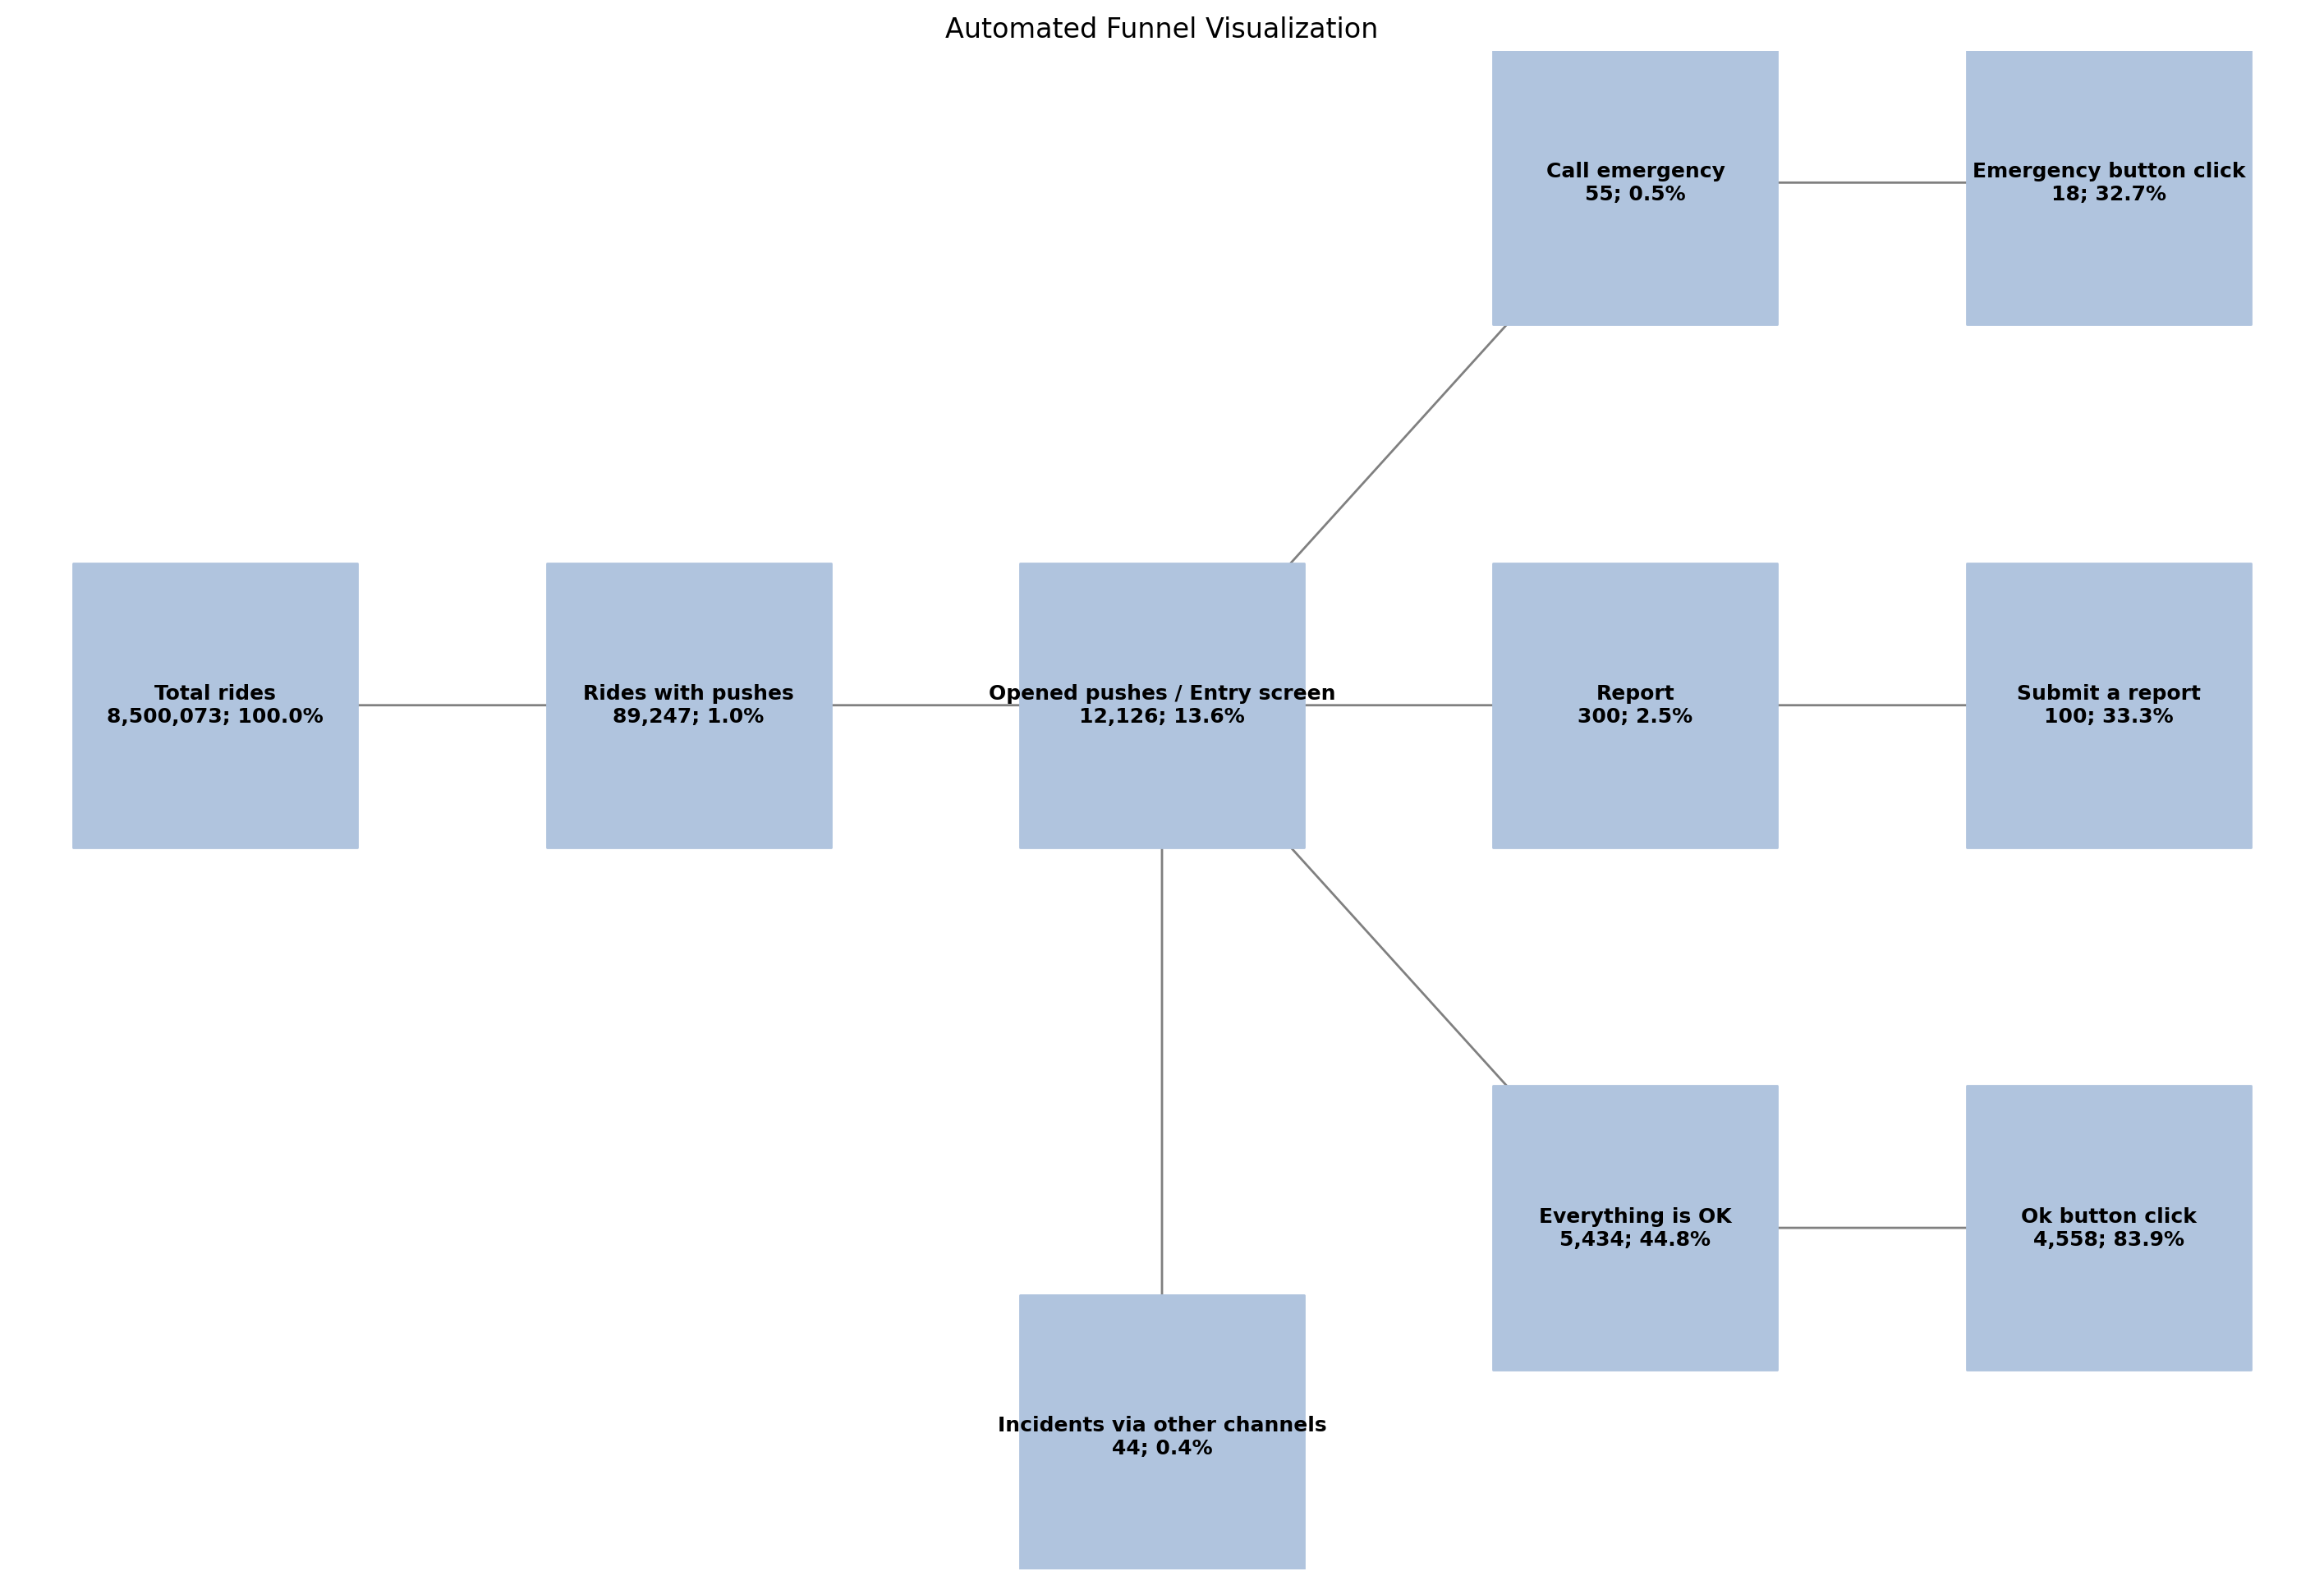

Calculated Funnel Values:
Total rides: Absolute = 8,500,073, Relative = 100.00%
Rides with pushes: Absolute = 89,247, Relative = 1.05%
Opened pushes / Entry screen: Absolute = 12,126, Relative = 13.59%
Incidents via other channels: Absolute = 44, Relative = 0.36%
Report: Absolute = 300, Relative = 2.47%
Submit a report: Absolute = 100, Relative = 33.33%
Everything is OK: Absolute = 5,434, Relative = 44.81%
Ok button click: Absolute = 4,558, Relative = 83.88%
Call emergency: Absolute = 55, Relative = 0.45%
Emergency button click: Absolute = 18, Relative = 32.73%


In [ ]:

data = {
    "rides": 8500073,
    "push_deliver": 89247,
    "client.intrip_entry.show": 12126,
    "push_open": 10981,
    "client.intrip_ok_button.click": 4558,
    "client.intrip_ok_button.show": 5400,
    "client.intrip_entry.click.ok": 5434,
    "client.intrip_entry.click.report": 300,
    "client.intrip_report.show": 299,
    "client.intrip_report.click": 100,
    "client.intrip_entry.click.call": 55,
    "offsite_incidents": 44,
    "safety_center.call_emergency_details.click": 18,
    "client.intrip_report_result.click": 6,
    "client.intrip_report_result.show": 6
}


funnel_steps = [
    ("Total rides", "rides", None),
    ("Rides with pushes", "push_deliver", "Total rides"),
    ("Opened pushes / Entry screen", "client.intrip_entry.show", "Rides with pushes"),
    ("Incidents via other channels", "offsite_incidents", "Opened pushes / Entry screen"),
    ("Report", "client.intrip_entry.click.report", "Opened pushes / Entry screen"),
    ("Submit a report", "client.intrip_report.click", "Report"),
    ("Everything is OK", "client.intrip_entry.click.ok", "Opened pushes / Entry screen"),
    ("Ok button click", "client.intrip_ok_button.click", "Everything is OK"),
    ("Call emergency", "client.intrip_entry.click.call", "Opened pushes / Entry screen"), 
    ("Emergency button click", "safety_center.call_emergency_details.click", "Call emergency")
]

calculated_values = {}

for step_name, data_key, parent_name in funnel_steps:
    absolute_value = data.get(data_key, 0)

    relative_value = 0.0
    if parent_name:
        parent_absolute_value = calculated_values[parent_name]["absolute"]
        if parent_absolute_value > 0:
            relative_value = (absolute_value / parent_absolute_value) * 100
        else:
            relative_value = 0.0
    else: 
        total_rides = data.get("rides", 0)
        if total_rides > 0:
            relative_value = (absolute_value / total_rides) * 100
        else:
            relative_value = 0.0

    calculated_values[step_name] = {
        "absolute": absolute_value,
        "relative": relative_value
    }

G = nx.DiGraph()

for step_name, values in calculated_values.items():
    label = f"{step_name}\n{values['absolute']:,}; {values['relative']:.1f}%"
    G.add_node(step_name, label=label)

edges = [
    ("Total rides", "Rides with pushes"),
    ("Rides with pushes", "Opened pushes / Entry screen"),
    ("Opened pushes / Entry screen", "Incidents via other channels"),
    ("Opened pushes / Entry screen", "Report"),
    ("Opened pushes / Entry screen", "Everything is OK"),
    ("Opened pushes / Entry screen", "Call emergency"), 
    ("Report", "Submit a report"),
    ("Everything is OK", "Ok button click"),
    ("Call emergency", "Emergency button click")
]

for u, v in edges:
    G.add_edge(u, v)

plt.figure(figsize=(18, 12)) 

pos = {
    "Total rides": (0, 0.5),
    "Rides with pushes": (0.2, 0.5),
    "Opened pushes / Entry screen": (0.4, 0.5),

    "Incidents via other channels": (0.4, 0.15), 

    "Report": (0.6, 0.5), 
    "Submit a report": (0.8, 0.5),

    "Everything is OK": (0.6, 0.25), 
    "Ok button click": (0.8, 0.25),

    "Call emergency": (0.6, 0.75), 
    "Emergency button click": (0.8, 0.75)
}

nx.draw_networkx_nodes(G, pos, node_color='lightsteelblue', node_shape='s', node_size=15500, alpha=1)

nx.draw_networkx_edges(G, pos, arrowstyle='-', arrowsize=10, edge_color='gray')

node_labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9, font_weight='bold',
                        verticalalignment='center')

plt.title("Automated Funnel Visualization")
plt.axis('off') 
plt.show()

print("Calculated Funnel Values:")
for step_name, values in calculated_values.items():
    print(f"{step_name}: Absolute = {values['absolute']:,}, Relative = {values['relative']:.2f}%")